# Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dyna

In [38]:
import sympy
from arsenal import timers, iterview, take
from IPython.display import HTML
from collections import defaultdict

# CKY

In [4]:
cky = dyna.Program("""
phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
total += phrase(s,0,N) * length(N).

inputs: rewrite(_,_,_); rewrite(_,_); word(_,_,_); length(_).
output: total.

""")

Below is example input data corresponding to parsing the input sentence "Papa ate the caviar with the spoon ." with a simple grammar.

In [5]:
cky_grammar = dyna.Program("""

% grammar rules
rewrite(s,np,vp) += 1.
rewrite(np,det,n) += 1.
rewrite(np,np,pp) += 1.
rewrite(vp,v,np) += 1.
rewrite(vp,vp,pp) += 1.
rewrite(pp,p,np) += 1.

rewrite(np,"Papa") += 1.
rewrite(v,"ate") += 1.
rewrite(vp,"ate") += 1.
rewrite(det,"the") += 1.
rewrite(n,"caviar") += 1.
rewrite(p,"with") += 1.
rewrite(n,"spoon") += 1.
rewrite(punc,".") += 1.
""")

cky_sentence = dyna.Program("""
% "Papa ate the caviar with the spoon."
length(7) += 1.
word("Papa",0,1) += 1.
word("ate",1,2) += 1.
word("the",2,3) += 1.
word("caviar",3,4) += 1.
word("with",4,5) += 1.
word("the",5,6) += 1.
word("spoon",6,7) += 1.
""")

cky_data = cky_sentence + cky_grammar

The value of `total` will equal the number of parses of the input sentence.  There are two parses of this sentences becase of the prepositional attachment ambiguity.

In [6]:
cky_sol = cky(cky_data).sol()
cky_sol.user_query('total')

{
  0: total += 2.0.
}

We can also instantiate the rules (several methods are available)

In [10]:
#(cky + cky_data).instantiate(cky_sol)
dyna.util.display_groundings(cky, cky_sol)

,"phrase(X,I,K) += rewrite(X,W) * word(W,I,K)"
1.0,"phrase(np,0,1) += rewrite(np,""Papa"") * word(""Papa"",0,1)"
1.0,"phrase(v,1,2) += rewrite(v,""ate"") * word(""ate"",1,2)"
1.0,"phrase(vp,1,2) += rewrite(vp,""ate"") * word(""ate"",1,2)"
1.0,"phrase(det,2,3) += rewrite(det,""the"") * word(""the"",2,3)"
1.0,"phrase(det,5,6) += rewrite(det,""the"") * word(""the"",5,6)"
1.0,"phrase(n,3,4) += rewrite(n,""caviar"") * word(""caviar"",3,4)"
1.0,"phrase(p,4,5) += rewrite(p,""with"") * word(""with"",4,5)"
1.0,"phrase(n,6,7) += rewrite(n,""spoon"") * word(""spoon"",6,7)"
,"phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K)"
1.0,"phrase(s,0,2) += rewrite(s,np,vp) * phrase(np,0,1) * phrase(vp,1,2)"


## Visualization

We can visualize the computation performed in the program as a computation graph.

In [11]:
#dyna.util.open_html\
((cky + cky_data).instantiate(cky_sol).coarse_hypergraph())

Hypergraph(nodes=40)

In [12]:
#dyna.util.open_html\
((cky + cky_data).derivations(10, 'total').render_graphviz())

Output()

We call these **derivations**.  Some authors call them **proofs**.

The computation graph is essentially a collection or derivations packed together such that common derivations are shared.  The computation graph allows us to represent a larger number of derivations compactly.

## Forward Chaining

Let's see how CKY works on our example data from earlier

In [13]:
p = cky + cky_data

**Forward chaining** is an iterative algorithm.  In each iteration, it applies the rules of the program to a **chart** (solution estimate) to derive the next chart.  Once the chart is unchanged, the algorithm halts.

We initialize to the empty chart (i.e., all items have value zero).

In [14]:
chart = dyna.Program(inputs='')

By repeatedly evaluating the cell below, we will see what the forward chaining steps do.

In [24]:
new_chart = p.step(chart)
dyna.util.display_chart_and_groundings(cky, chart, new_chart)
chart = new_chart

In [25]:
#p.instantiate(chart).coarse_hypergraph().graphviz().open()

In the thesis, we describe a more efficient *prioritized* forward chaining strategy that exploits sparsity in the computation graph.

**What about cyclical programs?**

In [26]:
p = dyna.Program("""
x += a * x.
x += 1.
a += 0.5.

outputs: x.
""")

In [27]:
p.coarse_hypergraph()

Hypergraph(nodes=2)

In [28]:
#chart = p.spawn()

In [29]:
#new_chart = p.step(chart)
#dyna.util.display_chart_and_groundings(p, chart, new_chart)
#chart = new_chart

In [30]:
p.fc(5).user_query('x')

{
  0: x += 1.9375.
}

In [31]:
p.fc(10).user_query('x')

{
  0: x += 1.998046875.
}

In [32]:
p.fc(200).user_query('x')

{
  0: x += 2.0.
}

Convergence rate depends on the value of $\texttt{a}$:  

- If $|\texttt{a}|$ is small, numerical convergence is fast

- If $|\texttt{a}| \ge 1$ forward chaining will diverge.

**A harder cyclical program.** Numerical convergence of forward chaining can be slow.  The following program shows a case where fixpoint iteration is slow to converge and Netwon's algorithm is much faster.

In [33]:
p = dyna.Program("""

x += 0.5 * x * x.
x += 0.5.

outputs: x.

""")

The solution to this program is `x = 1` (hint: use quadractic formula).

On this program, forward chaining converges very slowly.

In [34]:
p.fc(100)

{
  0: x += 0.9812084402587709.
}

In [35]:
p.fc(1000)

{
  0: x += 0.9980172182771205.
}

For difficult cyclical programs, we use a generalized Newton's algorithm to solve for the values.

In [36]:
p.newton(10)

{
  0: x += 0.9990234375.
}

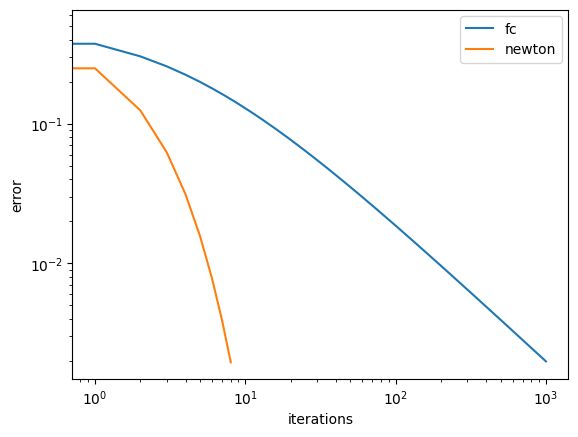

In [39]:
pl.loglog([abs(1-chart.rules[0].body[0]) for chart in take(1_000, p._fc()) if chart], label='fc')
pl.loglog([abs(1-chart.rules[0].body[0]) for (_, chart, _, _, _) in take(10, p._newton()) if chart], label='newton')
pl.ylabel('error')
pl.xlabel('iterations')
pl.legend(loc='best');

# Transformations

## Basic Unfold  and Fold

The example below illustrates fold and unfold.  The example uses the regular-expression semiring.

In [40]:
pqrst = dyna.Program("""
p += q * `t`.
q += `r`.
q += `s`.
""", semiring=dyna.Symbol)

In [41]:
pqrst.unfold(0,0).sort()

{
  0: p += r * t.
  1: p += s * t.
  2: q += r.
  3: q += s.
}

In [42]:
dyna.Program("""
p += `r` * `t`.
p += `s` * `t`.
q += `r`.
q += `s`.
""").megafolds()[0]

{
  0: p += q * t.
  1: q += r.
  2: q += s.
}

Value-preserving bijections between the derivation sets

In [43]:
pqrst.derivations(10,'X')

Output()

[p += (q += r) * t,
 p += (q += s) * t,
 q += r,
 q += s]

In [44]:
#pqrst.derivations(10,'X').transform(pqrst.unfold(0,0))   # transform implements the bijective mapping

In [45]:
html = [r'<table style="width: 100%"><tr><th style="width: 50%;">${\delta \in \mathfrak{p}\{ \cdot \}}$</th>'
        '<th style="width: 50%;">${\phi(\delta) \in \mathfrak{p}\'\{ \cdot \}}$</th></tr>']
for x in pqrst.derivations(10,'X'):
    y = pqrst.Transform(x, pqrst.unfold(0,0))        
    html.append(f'<tr><td>{x._repr_html_()}</td><td>{y._repr_html_()}</td></tr>')
html.append('</table>')
HTML(''.join(html))

${\delta \in \mathfrak{p}\{ \cdot \}}$,${\phi(\delta) \in \mathfrak{p}'\{ \cdot \}}$
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!-- Created with Inkscape (http://www.inkscape.org/) --> qr","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!-- Created with Inkscape (http://www.inkscape.org/) --> qr"
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!-- Created with Inkscape (http://www.inkscape.org/) --> qs","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!-- Created with Inkscape (http://www.inkscape.org/) --> qs"


## Length-4 paths

In [46]:
path4 = dyna.Program("""
total += w(Y₁,Y₂) * w(Y₂,Y₃) * w(Y₃,Y₄) * w(Y₄,Y₅).

inputs: w(_,_).
output: total.
""")

In [47]:
path4_input_type = """
w(I,J) += n(I) * n(J). 
inputs: n(_).
"""

In [48]:
dyna.gen_functor.reset()
np.random.seed(None)
candidate = path4.binarize()
print(candidate)
display(candidate.type_analysis(path4_input_type).runtime().x.expand())

{
  0: $gen1(Y₂) += $gen2(Y₃) * w(Y₂,Y₃).
  1: total += $gen1(Y₂) * w(Y₁,Y₂).
  2: $gen2(Y₃) += w(Y₃,Y₄) * w(Y₄,Y₅).
}


n**3 + 3*n**2 + 2*n + 4

In [49]:
path4_opt = path4.beam(50,5,verbosity=0).best.sort()
display(path4_opt)
display(path4_opt.type_analysis(path4_input_type).runtime().x.expand())

{
  0: $gen26(Y₄) += w(Y₄,Y₅).
  1: $gen3(Y₃) += $gen26(Y₄) * w(Y₃,Y₄).
  2: $gen8(Y₂) += $gen3(Y₃) * w(Y₂,Y₃).
  3: total += $gen8(Y₂) * w(Y₁,Y₂).
}

4*n**2 + 3*n + 5

In [50]:
#opt = path4.optimizer()
#opt.run(50)
#opt.to_collection().sort(dyna.Program.degrees)[:5]
#opt.to_collection().graph

## CKY - Program Improvement + Analysis

In [51]:
cky

{
  0: phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
  1: phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
  2: total += phrase(s,0,N) * length(N).
}

In [52]:
cky_optimized = cky.define('tmp(X,I,J,Z) += rewrite(X,Y,Z) * phrase(Y,I,J).').megafolds()[0]

In [53]:
cky_optimized

{
  0: phrase(X,I,K) += tmp(X,I,J,Z) * phrase(Z,J,K).
  1: phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
  2: total += phrase(s,0,N) * length(N).
  3: tmp(X,I,J,Z) += rewrite(X,Y,Z) * phrase(Y,I,J).
}

In [54]:
cky_input_type = """

params:
    k(X);   % grammar symbols
    w(W);   % sentence symbols
    n(I).   % sentence positions

word(W,I,K) += w(W) * n(I) * n(K).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

"""
cky_optimized.type_analysis(cky_input_type).runtime(fast_mode=1).x.expand()

k**3*n**2 + k**3 + k**2*n**3 + k**2*n**2 + k*n**2*w + n**2*w + 2*n + 8

In [55]:
cky_optimized.type_analysis()

TypeAnalyzer {
  length(+$Gen9)
  phrase(+$Gen4,+I,+K)
  rewrite(+$Gen1,+$Gen2,+$Gen3)
  rewrite(+$Gen4,+$Gen5)
  tmp(+X,+I,+K,+Z)
  total
  word(+$Gen6,+$Gen7,+$Gen8)
}

In [56]:
#cky.to_collection().eurekas()

Since the number of nonterminals over each span is small in this program the savings due to the "hook trick" are small.

In [57]:
D = cky_data

T = timers()
for _ in iterview(range(25)):
    with T['cky-optimized']:
        cky_optimized(D)    
    with T['cky-basic']:
        cky(D)
T.compare()

Output()

cky-basic is 1.0638x faster than cky-optimized (p=0.01232, mean: cky-optimized: 0.00621406, cky-basic: 0.0058411)


In [58]:
synthetic_data = dyna.Program("""
word(W,I,K) += w(W) * n(I) * n(K) * (K is I + 1).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

w("a").
k(a). k(b). k(c). k(d). k(e). k(f). k(s).
n(0). n(1). n(2). n(3). n(4). n(5).
""").sol()
#cky(synthetic_data).user_query('total')

D = synthetic_data

T = timers()
for _ in iterview(range(5)):
    with T['cky-optimized']:
        cky_optimized(D)    
    with T['cky-basic']:
        cky(D)
T.compare()

Output()

cky-optimized is 1.3369x faster than cky-basic (p=0.00794, mean: cky-basic: 0.697162, cky-optimized: 0.521491)


## CKY - Unfold Grammar

We can use unfold to specialize the program to the specific grammar

In [59]:
cky_data + cky

{
  0: length(7) += 1.
  1: word("Papa",0,1) += 1.
  2: word("ate",1,2) += 1.
  3: word("the",2,3) += 1.
  4: word("caviar",3,4) += 1.
  5: word("with",4,5) += 1.
  6: word("the",5,6) += 1.
  7: word("spoon",6,7) += 1.
  8: rewrite(s,np,vp) += 1.
  9: rewrite(np,det,n) += 1.
  10: rewrite(np,np,pp) += 1.
  11: rewrite(vp,v,np) += 1.
  12: rewrite(vp,vp,pp) += 1.
  13: rewrite(pp,p,np) += 1.
  14: rewrite(np,"Papa") += 1.
  15: rewrite(v,"ate") += 1.
  16: rewrite(vp,"ate") += 1.
  17: rewrite(det,"the") += 1.
  18: rewrite(n,"caviar") += 1.
  19: rewrite(p,"with") += 1.
  20: rewrite(n,"spoon") += 1.
  21: rewrite(punc,".") += 1.
  22: phrase(X,I,K) += rewrite(X,W) * word(W,I,K).
  23: phrase(X,I,K) += rewrite(X,Y,Z) * phrase(Y,I,J) * phrase(Z,J,K).
  24: total += phrase(s,0,N) * length(N).
}

In [60]:
cky_specialized = (cky + dyna.Program(cky_data)).set_input_types('').unfold(1,0).unfold(0,0).constant_folding()
cky_specialized

{
  0: total += phrase(s,0,N) * length(N).
  1: phrase(s,I,K) += phrase(np,I,J) * phrase(vp,J,K).
  2: phrase(np,I,K) += phrase(det,I,J) * phrase(n,J,K).
  3: phrase(np,I,K) += phrase(np,I,J) * phrase(pp,J,K).
  4: phrase(vp,I,K) += phrase(v,I,J) * phrase(np,J,K).
  5: phrase(vp,I,K) += phrase(vp,I,J) * phrase(pp,J,K).
  6: phrase(pp,I,K) += phrase(p,I,J) * phrase(np,J,K).
  7: phrase(np,I,K) += word("Papa",I,K).
  8: phrase(v,I,K) += word("ate",I,K).
  9: phrase(vp,I,K) += word("ate",I,K).
  10: phrase(det,I,K) += word("the",I,K).
  11: phrase(n,I,K) += word("caviar",I,K).
  12: phrase(p,I,K) += word("with",I,K).
  13: phrase(n,I,K) += word("spoon",I,K).
  14: phrase(punc,I,K) += word(".",I,K).
  15: length(7) += 1.0.
  16: word("Papa",0,1) += 1.0.
  17: word("ate",1,2) += 1.0.
  18: word("the",2,3) += 1.0.
  19: word("caviar",3,4) += 1.0.
  20: word("with",4,5) += 1.0.
  21: word("the",5,6) += 1.0.
  22: word("spoon",6,7) += 1.0.
  23: rewrite(s,np,vp) += 1.0.
  24: rewrite(np,det,n)

In [61]:
T = timers()
for _ in iterview(range(25)):
    with T['cky-optimized']:
        cky_specialized()    
    with T['cky-basic']:
        cky(cky_data)
T.compare()

Output()

cky-optimized is 1.1557x faster than cky-basic (p=0.00005, mean: cky-basic: 0.00515059, cky-optimized: 0.00445685)


## Generalized Unfold and Fold

### Unfolding the Geometric Series

In [62]:
geom = dyna.Program("""
x += `b`.
x += `a` * x.

output: x.
""", semiring=dyna.Symbol)

In [63]:
geom

{
  0: x += b.
  1: x += a * x.
}

Unfolding *once* does what we expect:

In [64]:
geom.unfold(1,1)

{
  0: x += b.
  1: x += a * b.
  2: x += a * a * x.
}

However, unfolding *twice* does something a little weird:

In [65]:
geom.unfold(1,1).unfold(2,2)

{
  0: x += b.
  1: x += a * b.
  2: x += a * a * b.
  3: x += a * a * a * b.
  4: x += a * a * a * a * x.
}

The recurrence has be unrolled to four levels rather than 3.

With generalized unfold, we can specify which program to use as auxiliary definitions:

In [66]:
geom.unfold(1,1).unfold(2,2,defs=geom)

{
  0: x += b.
  1: x += a * b.
  2: x += a * a * b.
  3: x += a * a * a * x.
}

We recover the ordinary "basic" behavior when `defs` is the current program.

## Total weight of all paths from `start` to `stop`

In [67]:
paths = dyna.Program("""

goal += start(I) * path(I,K) * stop(K).

path(I,K) += path(I,J) * edge(J,K).
path(I,I).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.

""")

In [68]:
paths1 = paths.define('startpath(K) += start(I) * path(I,K).')
paths1

{
  0: goal += start(I) * path(I,K) * stop(K).
  1: path(I,K) += path(I,J) * edge(J,K).
  2: path(I,I).
  3: startpath(K) += start(I) * path(I,K).
}

In [69]:
paths2 = paths1.megafolds(paths1)[0]
paths2

{
  0: goal += startpath(K) * stop(K).
  1: path(I,K) += path(I,J) * edge(J,K).
  2: path(I,I).
  3: startpath(K) += start(I) * path(I,K).
}

In [70]:
paths3 = paths2.unfold(3,1)
paths3

{
  0: goal += startpath(K) * stop(K).
  1: path(I,K) += path(I,J) * edge(J,K).
  2: path(I,I).
  3: startpath(K) += start(I) * path(I,J) * edge(J,K).
  4: startpath(K) += start(K).
}

In [71]:
paths4 = paths3.megafolds(paths1)[1]
paths4.sort()

{
  0: goal += startpath(K) * stop(K).
  1: path(I,K) += path(I,J) * edge(J,K).
  2: path(I,I).
  3: startpath(K) += startpath(J) * edge(J,K).
  4: startpath(K) += start(K).
}

In [72]:
paths4.prune().sort()

{
  0: goal += startpath(K) * stop(K).
  1: startpath(K) += startpath(J) * edge(J,K).
  2: startpath(K) += start(K).
}

## Crazier path example

The program below is a rather direct way to write the sum over all paths in a graph ending in a set `stop`.

In [73]:
explicit_path = dyna.Program("""

path([X]) += stop(X).
path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
goal += start(X) * path([X|Xs]).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.
""")

In [75]:
#explicit_path.type_analysis(max_depth=1)

In [76]:
path_data = dyna.Program("""
start(a) += 1.
edge(a,b) += 0.5.
edge(b,c) += 0.5.
edge(c,a) += 0.5.
stop(a) += 1.
""")

#dyna.graphs.WeightedGraph.from_program(path_data)

In [77]:
(explicit_path + path_data).fc(20)

{
  0: path([a]) += 1.0.
  1: path([a,b,c,a]) += 0.125.
  2: path([a,b,c,a,b,c,a]) += 0.015625.
  3: path([a,b,c,a,b,c,a,b,c,a]) += 0.001953125.
  4: path([a,b,c,a,b,c,a,b,c,a,b,c,a]) += 0.000244140625.
  5: path([a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 3.0517578125e-05.
  6: path([a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 3.814697265625e-06.
  7: path([b,c,a]) += 0.25.
  8: path([b,c,a,b,c,a]) += 0.03125.
  9: path([b,c,a,b,c,a,b,c,a]) += 0.00390625.
  10: path([b,c,a,b,c,a,b,c,a,b,c,a]) += 0.00048828125.
  11: path([b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 6.103515625e-05.
  12: path([b,c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 7.62939453125e-06.
  13: path([c,a]) += 0.5.
  14: path([c,a,b,c,a]) += 0.0625.
  15: path([c,a,b,c,a,b,c,a]) += 0.0078125.
  16: path([c,a,b,c,a,b,c,a,b,c,a]) += 0.0009765625.
  17: path([c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 0.0001220703125.
  18: path([c,a,b,c,a,b,c,a,b,c,a,b,c,a,b,c,a]) += 1.52587890625e-05.
  19: goal += 1.142852783203125.
  20: start(a) += 1.0.
  21: ed

In [78]:
opt = explicit_path.optimizer().run(500)
best = opt.optimize_plans().prune()
best

{
  0: goal += $gen130(X) * start(X).
  1: $gen130(X) += $gen130(X2) * edge(X,X2).
  2: $gen130(X) += stop(X).
}

In [79]:
path_input_type = """
start(I) += n(I).
edge(I,K) += n(I) * n(K).
stop(K) += n(K).
inputs: n(N).
"""

In [80]:
runtime = best.abbreviate().prune().type_analysis(path_input_type).runtime().x.expand()
#leading_term = max(runtime.as_coefficients_dict(), key=sympy.degree)
#leading_term
runtime

2*n**2 + 6*n + 11

In [81]:
explicit_path.abbreviate().prune().type_analysis(path_input_type).runtime().x.expand()

oo

# More

## CKY - Program Analysis

Simple input type specification

In [82]:
cky_input_type = """

params:
    k(X);   % grammar symbols
    w(W);   % sentence symbols
    n(I).   % sentence positions

word(W,I,K) += w(W) * n(I) * n(K) * (I < K).
length(N) += n(N).
rewrite(X,Y,Z) += k(X) * k(Y) * k(Z).
rewrite(X,W) += k(X) * w(W).

"""
cky_t = cky.type_analysis(cky_input_type, """
(I < K) :- (I < J), (J < K).
$fail :- (I < I).
""")
cky_t

TypeAnalyzer {
  length(N) += n(N)
  phrase(X,I,K) += n(I) * k(X) * (I < K) * n(K)
  rewrite(X,Y,Z) += k(Z) * k(Y) * k(X)
  rewrite(X,W) += w(W) * k(X)
  total
  word(W,I,K) += w(W) * n(K) * n(I) * (I < K)
}

Space complexity

In [83]:
cky_t.size().x

k**3 + k*n**2 + k*w + n**2*w + n + 1

Runtime complexity

In [84]:
cky_t.runtime(fast_mode=1).x.expand()

oo

## Semirings

### Boolean

In [85]:
(cky + cky_data).lift_semiring(dyna.Boolean).user_query('total')

{
  0: total += True.
}

### Top K

In [86]:
for x in (cky + cky_data).lift_semiring(dyna.LazySort).user_query('total').rules[0].body[0]:
    print()
    print(x.score, x.flat_data_list())


1 [rewrite(s,np,vp), rewrite(np,"Papa"), word("Papa",0,1), rewrite(vp,v,np), rewrite(v,"ate"), word("ate",1,2), rewrite(np,np,pp), rewrite(np,det,n), rewrite(det,"the"), word("the",2,3), rewrite(n,"caviar"), word("caviar",3,4), rewrite(pp,p,np), rewrite(p,"with"), word("with",4,5), rewrite(np,det,n), rewrite(det,"the"), word("the",5,6), rewrite(n,"spoon"), word("spoon",6,7), length(7)]

1 [rewrite(s,np,vp), rewrite(np,"Papa"), word("Papa",0,1), rewrite(vp,vp,pp), rewrite(vp,v,np), rewrite(v,"ate"), word("ate",1,2), rewrite(np,det,n), rewrite(det,"the"), word("the",2,3), rewrite(n,"caviar"), word("caviar",3,4), rewrite(pp,p,np), rewrite(p,"with"), word("with",4,5), rewrite(np,det,n), rewrite(det,"the"), word("the",5,6), rewrite(n,"spoon"), word("spoon",6,7), length(7)]


### Min-plus

In [87]:
(cky + cky_data).lift_semiring(dyna.MinPlus).user_query('total')

{
  0: total += MinPlus(21, (((rewrite(s,np,vp), (rewrite(np,"Papa"), word("Papa",0,1))), ((rewrite(vp,vp,pp), ((rewrite(vp,v,np), (rewrite(v,"ate"), word("ate",1,2))), ((rewrite(np,det,n), (rewrite(det,"the"), word("the",2,3))), (rewrite(n,"caviar"), word("caviar",3,4))))), ((rewrite(pp,p,np), (rewrite(p,"with"), word("with",4,5))), ((rewrite(np,det,n), (rewrite(det,"the"), word("the",5,6))), (rewrite(n,"spoon"), word("spoon",6,7)))))), length(7))).
}

### Regular expressions

Ten iterations of Newton is already as good as one thousand iterations of forward chaining!

In [88]:
class NewSymbol(dyna.Symbol):
    @classmethod
    def lift(cls, x, y):
        if y.fn == 'word': return dyna.Symbol(y.args[0])
        else: return dyna.Symbol.one

In [89]:
(cky + cky_data).lift_semiring(NewSymbol).user_query('total')

{
  0: total += Papa⋅ate⋅the⋅caviar⋅with⋅the⋅spoon.
}

## Basics

In [90]:
p = dyna.Program("""
a += 1.
a += 3.

b += 2 * a.
b += .5 * b.

c += d(1).
c += d(2).
c += d(3).
c += d("four").
c += d(foo(bar(5))).

d(1) += -5.
d(2) += 7.
d(3) += 13.

""")

p.newton()   # output is a special program where each right-hand sides is a constant value

{
  0: b += 16.0.
  1: a += 4.0.
  2: c += 15.0.
  3: d(1) += -5.0.
  4: d(2) += 7.0.
  5: d(3) += 13.0.
}

## Total Weight of all Paths

In [91]:
p = dyna.Program("""

goal += start(I) * path(I,K) * stop(K).

path(I,K) += edge(I,J) * path(J,K).
path(I,I).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.

""")

In [92]:
p

{
  0: goal += start(I) * path(I,K) * stop(K).
  1: path(I,K) += edge(I,J) * path(J,K).
  2: path(I,I).
}

This program defines `path` to be the total weight of all paths of length $\ge 0$.  This is also known as the reflexive and transitive closure of the `edge` relation.  We can derive the transitive closure (with out reflexivity) using the following transformation.  Notice that we did not change the meaning of `goal` (it still sums the length $=0$ paths), but the `path` relation has changed its meaning.

In [93]:
p.elim(2)

{
  0: goal += start(K) * stop(K).
  1: goal += start(I) * path(I,K) * stop(K).
  2: path(I,K) += edge(I,K).
  3: path(I,K) += edge(I,J) * path(J,K).
}

In [94]:
D = """
edge("Boston", "New York") += 2.
edge("Boston", "Chicago") += 12.
edge("Boston", "Miami") += 15.
edge("Denver", "Chicago") += 8.
edge("Denver", "Seattle") += 10.
edge("Denver", "Dallas") += 12.
edge("Chicago", "Denver") += 7.
edge("Chicago", "Boston") += 12.
edge("Chicago", "Seattle") += 10.
edge("Seattle", "Denver") += 8.
edge("Seattle", "San Francisco") += 9.
edge("Seattle", "Chicago") += 10.
edge("San Francisco", "Seattle") += 2.
edge("San Francisco", "Los Angeles") += 4.
edge("San Francisco", "Denver") += 12.
edge("Los Angeles", "San Francisco") += 2.
edge("Los Angeles", "Dallas") += 13.
edge("Los Angeles", "Miami") += 2.
edge("Miami", "Dallas") += 6.
edge("Miami", "New York") += 9.
edge("Miami", "Boston") += 15.
edge("Dallas", "Los Angeles") += 14.
edge("Dallas", "Denver") += 12.
edge("Dallas", "Miami") += 9.
edge("New York", "Boston") += 2.
edge("New York", "Miami") += 13.
edge("New York", "Chicago") += 8.
"""

#display(dyna.graphs.WeightedGraph.from_program(D))

In [95]:
from dyna import MinPlus
p.lift_semiring(MinPlus)(D, solver=2).sol().user_lookup('path("New York", J)')

{
  0: path("New York","New York") += MinPlus(0.0, ()).
  1: path("New York","Miami") += MinPlus(13, edge("New York","Miami")).
  2: path("New York","Chicago") += MinPlus(8, edge("New York","Chicago")).
  3: path("New York","Boston") += MinPlus(2, edge("New York","Boston")).
  4: path("New York","Dallas") += MinPlus(19, (edge("New York","Miami"), edge("Miami","Dallas"))).
  5: path("New York","Denver") += MinPlus(15, (edge("New York","Chicago"), edge("Chicago","Denver"))).
  6: path("New York","Seattle") += MinPlus(18, (edge("New York","Chicago"), edge("Chicago","Seattle"))).
  7: path("New York","Los Angeles") += MinPlus(31, (edge("New York","Chicago"), (edge("Chicago","Seattle"), (edge("Seattle","San Francisco"), edge("San Francisco","Los Angeles"))))).
  8: path("New York","San Francisco") += MinPlus(27, (edge("New York","Chicago"), (edge("Chicago","Seattle"), edge("Seattle","San Francisco")))).
}

In [96]:
D = dyna.Program("""
start(a) += 1.
edge(a,b) += 0.5.
edge(b,c) += 0.5.
edge(c,a) += 0.5.
stop(a) += 1.
""")

D = dyna.Program("""
start(a) += 1.
edge(a,b) += 1.
edge(b,d) += 1.
edge(a,c) += 1.
edge(c,d) += 1.
edge(b,c) += 1.
stop(d) += 1.
""")


#dyna.graphs.WeightedGraph.from_program(D)

In [97]:
sol = (p + D).fc(10)
sol

{
  0: goal += 3.0.
  1: path(a,d) += 3.0.
  2: path(a,c) += 2.0.
  3: path(a,b) += 1.0.
  4: path(b,d) += 2.0.
  5: path(c,d) += 1.0.
  6: path(b,c) += 1.0.
  7: path(I,I) += 1.0.
  8: start(a) += 1.0.
  9: edge(a,b) += 1.0.
  10: edge(b,d) += 1.0.
  11: edge(a,c) += 1.0.
  12: edge(c,d) += 1.0.
  13: edge(b,c) += 1.0.
  14: stop(d) += 1.0.
}

In [98]:
# example is a little trickier than we want because of the nonground item
(p + D).instantiate(sol).prune().coarse_hypergraph()   

Hypergraph(nodes=12)

Enumerate derivations

In [99]:
(p + D).derivations(5, 'goal')

Output()

[goal += (start(a) += 1) * (path(a,d) += (edge(a,b) += 1) * (path(b,d) += (edge(b,d) += 1) * (path(d,d)))) * (stop(d) += 1),
 goal += (start(a) += 1) * (path(a,d) += (edge(a,b) += 1) * (path(b,d) += (edge(b,c) += 1) * (path(c,d) += (edge(c,d) += 1) * (path(d,d))))) * (stop(d) += 1),
 goal += (start(a) += 1) * (path(a,d) += (edge(a,c) += 1) * (path(c,d) += (edge(c,d) += 1) * (path(d,d)))) * (stop(d) += 1)]

In [100]:
p = dyna.Program("""

path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
path([X]) += stop(X).
goal += start(X) * path([X|Xs]).

inputs: start(_); edge(_,_); stop(_).
outputs: goal.
""")

In [101]:
#def instantiated_size(p): return len(p(D).ground_out())

In [102]:
#p.to_collection().map(lambda p: p(D).ground_out())

In [103]:
m = dyna.make_smt_measure(p)

C = (p.to_collection()
 .eurekas()
 .unfolds_first()
 .dedup()
 .folds_seq()
 .filter(m.safe)
 .prune_fast()
 .dedup()
)

print(f'{len(C)} nodes')
C.sort(dyna.Program.degrees)[:3]

15 nodes


[{
   0: $gen304(X) += $gen304(X2) * edge(X,X2).
   1: goal += $gen304(X) * start(X).
   2: $gen304(X) += stop(X).
 },
 {
   0: path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
   1: path([X]) += stop(X).
   2: goal += start(X) * path([X|Xs]).
 },
 {
   0: goal += $gen304(X) * start(X).
   1: path([X1,X2|Xs]) += edge(X1,X2) * path([X2|Xs]).
   2: path([X]) += stop(X).
   3: $gen304(X) += path([X|Xs]).
 }]

In [104]:
filename = '/tmp/tmp.html'
with open(filename, 'w', encoding='utf-8') as f:
    f.write(C.graph._repr_html_())

In [105]:
C.graph

<ProgramGraph 17 nodes, 17 hyperedges>

In [106]:
from IPython.display import FileLink, FileLinks
FileLink(filename)

/tmp/tmp.html

In [107]:
optimizer = p.optimizer(p_greedy=0, seed=0)
optimizer.run(1500).optimize_plans().prune()

{
  0: $gen305(X) += $gen305(X2) * edge(X,X2).
  1: goal += $gen305(X) * start(X).
  2: $gen305(X) += stop(X).
}

## Type-based Program Specialization

In [108]:
q = dyna.Program("""
goal += a(I,I).
a(I,K) += b(I,J) * c(J,K).
goal += dead(X).

input: b(_,_); c(_,_).
output: goal.
""")

In [109]:
q.type_analysis()

TypeAnalyzer {
  a(+$Gen72,+K)
  b(+$Gen72,+$Gen73)
  c(+$Gen74,+$Gen75)
  goal
}

In [110]:
q.usefulness_analysis()

TypeAnalyzer {
  a(+I,+I)
  b(+I,+J)
  c(+J,+I)
  goal
}

In [111]:
q.abbreviate(types=q.usefulness_analysis()).prune().sort()

{
  0: a_0(K) += b_1(K,J) * c_2(J,K).
  1: b_1(I,J) += b(I,J).
  2: c_2(J,I) += c(J,I).
  3: goal += goal_3.
  4: goal_3 += a_0(I).
}

Bounds

In [112]:
import dyna.analyze.runtime
#n = dyna.analyze.runtime._syms['n']   # symbol name to make it orange
#n.name = colors.orange % 'n'

In [113]:
q.type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""").show_runtime()

goal += a(I,I)
n + 1
a(I,K) += b(I,J) * c(J,K)
n**2*(n + 1) + 1
goal += dead(X)
1


In [114]:
q.prune(specialize=True).type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""").show_runtime()

goal += a(I,I)
n + 1
a(K,K) += b(K,J) * c(J,K)
2*n**2 + 1


In [115]:
S = q.type_analysis("""
b(I,J) :- n(I), n(J).
c(I,J) :- n(I), n(J).
inputs: n(_).
""")

In [116]:
S.show_size(full=True)

print(colors.light.magenta % '\noverall', S.size())


b(I,J) += n(I) * n(J)
          {}  n**2
         {I}  n
         {J}  n
      {J, I}  1

c(I,J) += n(J) * n(I)
          {}  n**2
         {I}  n
         {J}  n
      {I, J}  1

a(I,K) += n(K) * n(I)
          {}  n**2
         {I}  n
         {K}  n
      {I, K}  1

goal
          {}  1

overall 3*n**2 + 1


## Peano

This example shows how the left-corner transformation can be used to speed-up the following sum over weighted peano numbers.

In [117]:
peano = dyna.Program("""
peano(z) += 1.
peano(s(N)) += a * peano(N).
a += .5.

goal += peano(N).

outputs: goal.

""")

In [118]:
sol = peano.fc(30)
sol

{
  0: peano(z) += 1.0.
  1: peano(s(z)) += 0.5.
  2: peano(s(s(z))) += 0.25.
  3: peano(s(s(s(z)))) += 0.125.
  4: peano(s(s(s(s(z))))) += 0.0625.
  5: peano(s(s(s(s(s(z)))))) += 0.03125.
  6: peano(s(s(s(s(s(s(z))))))) += 0.015625.
  7: peano(s(s(s(s(s(s(s(z)))))))) += 0.0078125.
  8: peano(s(s(s(s(s(s(s(s(z))))))))) += 0.00390625.
  9: peano(s(s(s(s(s(s(s(s(s(z)))))))))) += 0.001953125.
  10: peano(s(s(s(s(s(s(s(s(s(s(z))))))))))) += 0.0009765625.
  11: peano(s(s(s(s(s(s(s(s(s(s(s(z)))))))))))) += 0.00048828125.
  12: peano(s(s(s(s(s(s(s(s(s(s(s(s(z))))))))))))) += 0.000244140625.
  13: peano(s(s(s(s(s(s(s(s(s(s(s(s(s(z)))))))))))))) += 0.0001220703125.
  14: peano(s(s(s(s(s(s(s(s(s(s(s(s(s(s(z))))))))))))))) += 6.103515625e-05.
  15: peano(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(z)))))))))))))))) += 3.0517578125e-05.
  16: peano(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(z))))))))))))))))) += 1.52587890625e-05.
  17: peano(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(s(z)))))))))))))))))) += 7.62939453125e-06.
  18

In [119]:
sol.user_lookup('goal')    # approximation to goal is pretty accurate if |a| is small, if |a| >= 1 it diverges.

{
  0: goal += 1.9999998807907104.
}

The following mysterious transformation makes the computation of `goal` program run efficiently:

In [120]:
peano

{
  0: peano(z) += 1.
  1: peano(s(N)) += a * peano(N).
  2: a += 0.5.
  3: goal += peano(N).
}

In [121]:
peano_fast = peano.lct({3:0, 1:1}).elim(0).elim(0).prune_fast()
peano_fast

{
  0: (peano(s(N)) / peano(N)) += a.
  1: (Tmp / peano(N)) += a * Tmp / peano(s(N)).
  2: $other(a) += 0.5.
  3: (goal / peano(N)) += 1.0.
  4: a += $other(a).
  5: a += a / peano(z).
  6: goal += goal / peano(z).
}

Now, the program runs efficiently as the new items `(goal / peano($X0)` have `$X0` uninstantiated.

In [123]:
peano_fast.prune(specialize=0).sol()

{
  0: $other(a) += 0.5.
  1: (goal / peano($X0)) += 1.9999998807907104.
  2: a += 0.5.
  3: goal += 1.9999998807907104.
}